In [397]:
import random
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys	 # max float
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [398]:
df = pd.read_csv('dataIntel.csv')

In [399]:
df.head(10)

,Unnamed: 0,DATE,TIME,EPOCH,NODEID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE,x_coord,y_coord
0,0,2004-02-28,01:08:45.992524,22,1,19.1456,38.9401,45.08,2.68742,10,7
1,1,2004-02-28,01:08:45.992525,25,2,19.1456,38.8379,45.08,2.69964,37,73
2,2,2004-02-28,01:08:45.992526,58,3,19.0084,38.9401,43.24,2.69964,87,8
3,3,2004-02-28,01:08:45.992527,62,4,18.9986,38.9742,43.24,2.68742,8,96
4,4,2004-02-28,01:08:45.992528,21,5,19.5670,39.6878,121.44,2.67532,8,57
5,5,2004-02-28,01:08:45.992529,25,6,19.5376,39.7557,121.44,2.67532,37,54
6,6,2004-02-28,01:08:45.992530,58,7,19.4788,39.6878,121.44,2.66332,100,51
7,7,2004-02-28,01:08:45.992531,61,8,19.4494,39.7217,121.44,2.67532,68,41
8,8,2004-02-28,01:08:45.992532,23060,9,21.2036,40.7706,50.60,2.61639,12,58
9,9,2004-02-28,01:08:45.992533,32667,10,19.6944,48.5139,1.84,2.32910,77,3


In [400]:
for i in range(0,100):
    df['NODEID'][i] = i

df.head(10)

C:\Users\goyal\AppData\Local\Temp/ipykernel_188/761928403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NODEID'][i] = i


,Unnamed: 0,DATE,TIME,EPOCH,NODEID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE,x_coord,y_coord
0,0,2004-02-28,01:08:45.992524,22,0,19.1456,38.9401,45.08,2.68742,10,7
1,1,2004-02-28,01:08:45.992525,25,1,19.1456,38.8379,45.08,2.69964,37,73
2,2,2004-02-28,01:08:45.992526,58,2,19.0084,38.9401,43.24,2.69964,87,8
3,3,2004-02-28,01:08:45.992527,62,3,18.9986,38.9742,43.24,2.68742,8,96
4,4,2004-02-28,01:08:45.992528,21,4,19.5670,39.6878,121.44,2.67532,8,57
5,5,2004-02-28,01:08:45.992529,25,5,19.5376,39.7557,121.44,2.67532,37,54
6,6,2004-02-28,01:08:45.992530,58,6,19.4788,39.6878,121.44,2.66332,100,51
7,7,2004-02-28,01:08:45.992531,61,7,19.4494,39.7217,121.44,2.67532,68,41
8,8,2004-02-28,01:08:45.992532,23060,8,21.2036,40.7706,50.60,2.61639,12,58
9,9,2004-02-28,01:08:45.992533,32667,9,19.6944,48.5139,1.84,2.32910,77,3


In [401]:
x = []
y = []
for i in range(len(df)):
    x.append(df['x_coord'][i])
    y.append(df['y_coord'][i])




In [402]:
# global variables
global xc,yc,A,xbs,ybs,NCH,L,Reg,efs,emp,dth,N,Eda,Eelc # global variables
xc = 50 # centroid x coordinate
yc = 50 # centroid y coordinate
A = 0.5
xbs = 0 # base station x coordinate
ybs = 0 # base station y coordinate
NCH = 10 # number of cluster heads
L = 4000 # packet size (4000 bit)
Reg = 100 # region size (100m*100m)
efs = 10 * pow(10,-12) # energy factor for free space enviornment (10pj/bit/m^2)
emp = 0.0013 * pow(10,-12) # energy factor for multi space environment
dth = 88 # threshold distance
N = 100 #number of nodes
Eda = 5 * pow(10,-9) #energy consumption per bit during the data aggregation operation (5nj/bit/signal)
Eelc = 50 * pow(10,-9) #  energy consumption during 1-bit transmission or reception (50nj/bit/signal)





In [403]:
# Node Class
class Node:

    # constructor
    def __init__(self,x,y,id):
        self.x = x
        self.y = y
        self.id = id
        self.ein = 0.5
        self.isDead = True if self.ein <= 0 else False  # isDead is True if energy is 0 or less
        self.On = self.findOn()
        self.isCH = 0
        self.ClusterNumber = -1
        self.isDirect = True if self.On == 1 else False
        self.CHS = []
    
    def position(self):
        print(self.x,self.y)
    
    def dn2bs(self):   # node to base station distance
        return math.sqrt((self.x - xbs)**2 + (self.y - ybs)**2)
    
    def dn2n(self,xi,yi):  #node to particular node distance
        return math.sqrt((self.x - xi)**2 + (self.y - yi)**2)

    def dn2c(self):   # node to centroid distance
        return math.sqrt((self.x - xc)**2 + (self.y - yc)**2)

    # calculate On
    def findOn(self):
        Emean = 0.1
        Eres = 0
        if(self.dn2bs() < dth):
            Eres = self.ein - (L*Eelc + L*efs*self.dn2bs()**2)
        else:
            Eres = self.ein - (L*Eelc + L*emp*self.dn2bs()**4)
        
        if(Eres >= Emean and self.dn2bs() < dth):
            return 1
        else:
            return 0

    



In [404]:
Nodes = []
for i in range(0,100):
    obj = Node(x[i],y[i],i)
    Nodes.append(obj)

In [405]:
# Calculate Energies
def findResidualTotal(Nodes):  # Residual Energy of all nodes
    Eres = []
    print(type(Nodes))
    for i in range(0,len(Nodes)):
        Eres.append(Nodes[i].ein - (L*Eelc + L*efs*Nodes[i].dn2bs()**2))
    return Eres

def findResidual(Node):  # Residual Energy of a particular node
    Eres = Node.ein - (L*Eelc + L*efs*Node.dn2bs()**2)
    return Eres


def findETx(d):  # energy consumption for transmission
    if(d < dth):
        return L*Eelc + L*efs*d**2
    else:
        return L*Eelc + L*emp*d**4

def findERx(): # energy consumption for reception
    return L*Eelc








In [406]:
Eres = findResidual(Nodes[3])
Eres

0.4994288

In [407]:
# Number of Alive Nodes
def findAliveNodes(Nodes):
    count = 0
    for i in range(0,len(Nodes)):
        if(Nodes[i].On == 0 and Nodes[i].ein > 0):
            count += 1
    return count

In [408]:
Na = findAliveNodes(Nodes)
print(Na)

33


In [409]:
#   Count of Direct Nodes
def findDirectNodes(Nodes):
    count = 0
    for i in range(0,len(Nodes)):
        if(Nodes[i].On == 1):
            count += 1
    return count

In [410]:
ds = findDirectNodes(Nodes)
print(ds)


67


In [411]:
# Optimum Number of K
def findKopt(Na):
    dbs = 50
    Kopt = int((math.sqrt(Na/(2*math.pi)))*(math.sqrt(efs/emp))*(Reg/dbs**2)) # optimum number of Cluster Heads
    return Kopt

Kopt = findKopt(Na)
Kopt  

8

In [412]:
def findNc(Kopt,Na):
    Nc = int(Na/ Kopt) # optimum number of nodes in each cluster
    return Nc

Nc = findNc(Kopt,Na)
Nc


4

In [413]:
# find x1
def findx1(Node):
    return findResidual(Node)/Node.ein

# dmax
def findDmax(Nodes,Nc):
    d =[]
    for i in range(0,Nc):
        d.append(Nodes[i].dn2c())
    return max(d)

dmax = findDmax(Nodes,Nc)

# find x2
def findX2(Node,dmax):
    return (dmax - Node.dn2c())/dmax

# find x2dash
def findX2dash(Node,dmax):
    return (Node.dn2c()-dmax)/Node.dn2c()





In [414]:
# FCH Function
def findFCH(Nodes,dmax):
    FCH = []
    alpha = 0.8
    ans = 0
    for i in range(0,100):
        if(Nodes[i].isDirect == False):
            if(Nodes[i].dn2c() < dmax):
                ans = alpha*findx1(Nodes[i]) + (1-alpha)*findX2(Nodes[i],dmax)
                FCH.append(ans)
            elif(Nodes[i].dn2c() == dmax):
                ans = findx1(Nodes[i])
                FCH.append(ans)
            else:
                ans = alpha*findx1(Nodes[i]) + (1-alpha)*findX2dash(Nodes[i],dmax)
                FCH.append(ans)
        else:
            FCH.append(-1)
        
    return FCH


    

In [415]:
FCH = findFCH(Nodes,dmax)
print(FCH)



[-1, -1, -1, 0.9988576, -1, -1, 0.8383011063782272, -1, -1, -1, 0.8020709379216264, 0.8801986983161102, -1, 0.8775540633087218, -1, -1, 0.9150445120492653, -1, -1, -1, 0.8463577617290194, 0.9374088239144324, 0.8028442144494727, -1, -1, -1, -1, 0.8146684388541422, 0.8407766555511752, -1, 0.8769650330349845, 0.89901632, -1, -1, -1, -1, 0.8556716937178307, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.905798559379694, -1, 0.9150445120492653, -1, 0.9064132277340667, -1, 0.8291725202575378, -1, -1, -1, -1, -1, -1, 0.937486005323951, 0.8679705842071402, -1, -1, -1, -1, 0.8993648621009209, -1, -1, 0.8590363979430183, -1, -1, 0.8245921692409958, -1, 0.8481613010679742, 0.8035340904117767, -1, 0.875902883123951, -1, -1, 0.8062452633832865, -1, 0.8304570428128965, -1, -1, 0.8246619930842531, -1, -1, -1, 0.8256016174715288, -1, -1, 0.8512330772143748, 0.8594467014432547, -1, -1, -1, -1, 0.849063215269156]


In [416]:
C = copy.deepcopy(FCH)
def findCH(FCH,Kopt):
    FCH.sort(reverse=True)
    FCH[0:Kopt]
    return FCH[0:Kopt]  # Cluster Head List

CH = findCH(FCH,Kopt)
print(CH)


[0.9988576, 0.937486005323951, 0.9374088239144324, 0.9150445120492653, 0.9150445120492653, 0.9064132277340667, 0.905798559379694, 0.8993648621009209]


In [417]:
count = 0
for i in range(0,len(FCH)):
    if(FCH[i] == -1):
        count += 1
print(count)

67


In [418]:
a = Nodes[6].y
print(a)

51


In [419]:
def make_dataframe(df,Kopt):
    df2 = df['NODEID']
    df2 = pd.DataFrame(df2)
    df2['x_coord'] = x
    df2['y_coord'] = y
    df2['FCH'] = C
    # Check node is cluster head or not
    df2['CH'] = df2['FCH'].apply(lambda x: 1 if x >= FCH[Kopt-1] else 0)
    return df2

In [420]:
df2 = make_dataframe(df,Kopt)
df2.head(50)

,NODEID,x_coord,y_coord,FCH,CH
0,0,10,7,-1.000000,0
1,1,37,73,-1.000000,0
2,2,87,8,-1.000000,0
3,3,8,96,0.998858,1
4,4,8,57,-1.000000,0
5,5,37,54,-1.000000,0
6,6,100,51,0.838301,0
7,7,68,41,-1.000000,0
8,8,12,58,-1.000000,0
9,9,77,3,-1.000000,0


In [421]:

def makeClusterHeads(df2):
    ClusterHeads = []
    for i in range(0,100):
        if(df2['CH'][i]==1):
            ClusterHeads.append(Nodes[i])
    return ClusterHeads

ClusterHeads = makeClusterHeads(df2)
for i in range(0,len(ClusterHeads)):    
    print(ClusterHeads[i].id)








3
16
21
48
50
52
61
67


In [422]:
# Every Node to Every Cluster Head Distance

def findCD(Nodes,ClusterHeads):
    dist = [] # empty dictionary
    for i in range(0,len(ClusterHeads)):
        li = []
        for j in range(0,len(Nodes)):
            if(Nodes[j].isDirect == False):
                li.append(Nodes[j].dn2n(ClusterHeads[i].x,ClusterHeads[i].y))
        dist.append(li)
    return dist

In [423]:
for i in range(0,len(ClusterHeads)):
    print(ClusterHeads[i].id)

3
16
21
48
50
52
61
67


In [424]:
def findCHDistance(Nodes,ClusterHeads):
    for i in range(0,100):
        if(Nodes[i].isDirect == False):
            for j in range(0,len(ClusterHeads)):
                if(len(Nodes[i].CHS) < len(ClusterHeads)):
                    Nodes[i].CHS.append(Nodes[i].dn2n(ClusterHeads[j].x,ClusterHeads[j].y))

        


           

In [425]:
findCHDistance(Nodes,ClusterHeads)
Nodes[3].CHS

[0.0,
 67.11929677819934,
 69.6419413859206,
 43.46262762420146,
 67.11929677819934,
 80.1311425102625,
 66.37017402418047,
 81.41252974819048]

In [426]:
def makeAvailable():
    Avail = [1 for i in range(0,100)]  # Available Nodes
    for i in range(0,100):
        if(Nodes[i].isDirect == True):
            Avail[i] = -1
    return Avail

Avail = makeAvailable()

In [427]:
temp = {}
for i in range(0,len(Nodes[3].CHS)):
    temp['CH{}'.format(i+1)] = Nodes[3].CHS[i]

sorted_temp = dict(sorted(temp.items(), key=lambda item: item[1]))
sorted_temp

{'CH1': 0.0,
 'CH4': 43.46262762420146,
 'CH7': 66.37017402418047,
 'CH2': 67.11929677819934,
 'CH5': 67.11929677819934,
 'CH3': 69.6419413859206,
 'CH6': 80.1311425102625,
 'CH8': 81.41252974819048}

In [428]:
def findKeyValue(keys,values,value):
    for i in range(0,len(values)):
        if(values[i] == value):
            return keys[i]

In [429]:
# Find Cluster Number for Every Node
def findClusterNumber(Nodes,ClusterHeads,Avail,Nc,Kopt):
    ans = []
    k = [Nc-1 for i in range(len(ClusterHeads))]  # Counter array for Nc in Cluster 
    if((100 - findDirectNodes(Nodes))%2 == 1):
        k[len(k)-1] = Nc  
    for i in range(0,100):
        if(Nodes[i].isDirect == True):
            ans.append(-1)
        elif(Nodes[i] in ClusterHeads):
            ans.append(0)
        else:   
            temp = {}
            for j in range(0,len(ClusterHeads)):
                temp['CH{}'.format(j+1)] = Nodes[i].CHS[j]
            sorted_temp = dict(sorted(temp.items(), key=lambda item: item[1]))
            keys = list(sorted_temp.keys())
            values = list(sorted_temp.values())
            j = 0
            while(j<Kopt):
                if(values[j] != 0 and Avail[i] == 1):
                    key = findKeyValue(keys,values,values[j])
                    if(k[j] > 0):
                        ans.append(int(key[2])) # if CH1 then appends 1
                        k[j] -= 1
                        Avail[i] = 0
                        break
                    else:
                        j += 1
                else:
                    j += 1

            
    return ans

                    

In [430]:
ClusterNum = findClusterNumber(Nodes,ClusterHeads,Avail,Nc,Kopt)
print(ClusterNum)
print(len(ClusterNum))

[-1, -1, -1, 0, -1, -1, 8, -1, -1, -1, 2, 8, -1, 2, -1, -1, 0, -1, -1, -1, 6, 0, 2, -1, -1, -1, -1, 7, 3, -1, 3, 3, -1, -1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, 0, -1, 6, -1, -1, -1, -1, -1, -1, 0, 2, -1, -1, -1, -1, 0, -1, -1, 2, -1, -1, 3, -1, 2, 3, -1, 6, -1, -1, 4, -1, 4, -1, -1, 6, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 8]
100


In [431]:
def addWhichCH(df2):
    df2['whichCH'] = ClusterNum
    return df2

df2 = addWhichCH(df2)
df2[1:10]

,NODEID,x_coord,y_coord,FCH,CH,whichCH
1,1,37,73,-1.000000,0,-1
2,2,87,8,-1.000000,0,-1
3,3,8,96,0.998858,1,0
4,4,8,57,-1.000000,0,-1
5,5,37,54,-1.000000,0,-1
6,6,100,51,0.838301,0,8
7,7,68,41,-1.000000,0,-1
8,8,12,58,-1.000000,0,-1
9,9,77,3,-1.000000,0,-1


In [432]:
#df2.to_csv('ClusteredData2.csv')

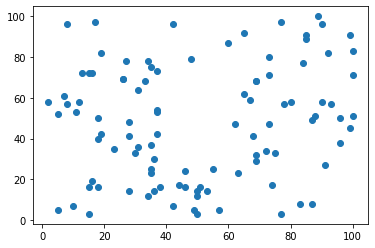

In [433]:
plt.scatter(df2['x_coord'],df2['y_coord'])
plt.show()

In [434]:
def addClusterNumber(df2):
    Cluster = copy.deepcopy(list(df2['whichCH']))
    c = 1
    for i in range(0,len(Cluster)):
        if(Cluster[i] == 0):
            Cluster[i] = c
            c += 1

    df2['ClusterNumber'] = Cluster
    return df2

df2 = addClusterNumber(df2)
df2[1:50]

,NODEID,x_coord,y_coord,FCH,CH,whichCH,ClusterNumber
1,1,37,73,-1.000000,0,-1,-1
2,2,87,8,-1.000000,0,-1,-1
3,3,8,96,0.998858,1,0,1
4,4,8,57,-1.000000,0,-1,-1
5,5,37,54,-1.000000,0,-1,-1
6,6,100,51,0.838301,0,8,8
7,7,68,41,-1.000000,0,-1,-1
8,8,12,58,-1.000000,0,-1,-1
9,9,77,3,-1.000000,0,-1,-1
10,10,89,100,0.802071,0,2,2


In [435]:
def updateisCH(df2,Nodes):
    for i in range(0,100):
        Nodes[i].isCH = df2['CH'][i]
        Nodes[i].ClusterNumber = df2['ClusterNumber'][i]

updateisCH(df2,Nodes) 

# Energy Loss During Transmission Phase

In [436]:
#In case of Direct Nodes
def findEnergyDirectNodes(Nodes):
    for i in range(0,100):
        if(Nodes[i].isDirect == True):
            d = Nodes[i].dn2bs()
            Nodes[i].ein = Nodes[i].ein - (findETx(d))


findEnergyDirectNodes(Nodes)



In [437]:
for i in range(0,10):
    print(Nodes[i].ein)

0.49979404
0.49953208
0.49949468
0.5
0.49966748
0.4996286
0.5
0.4995478
0.49965968
0.49956248


In [438]:
# In case of Non Direct Nodes
def findEnergyNonDirectNodes(ClusterHeads,Nodes):
    for i in range(0,100):
        if(Nodes[i].isDirect == False):
            X = ClusterHeads[Nodes[i].ClusterNumber-1].x
            Y = ClusterHeads[Nodes[i].ClusterNumber-1].y
            d = Nodes[i].dn2n(X,Y)
            Nodes[i].ein = Nodes[i].ein - (findETx(d)) # Transmission Energy loss by Cluster Nodes during transmitting
            ClusterHeads[Nodes[i].ClusterNumber-1].ein = ClusterHeads[Nodes[i].ClusterNumber-1].ein - (findERx()) # Transmission Energy loss by Cluster Head during receiving the data
findEnergyNonDirectNodes(ClusterHeads,Nodes)

In [439]:
for i in range(0,10):
    print(Nodes[i].ein)

0.49979404
0.49953208
0.49949468
0.4990000000000001
0.49966748
0.4996286
0.49978204
0.4995478
0.49965968
0.49956248


# Proposed Fitness Function Implementation

In [440]:
A = 0.5

# base station coordinates
x_bs = 0
y_bs = 0

def CH2BS(x_ch,y_ch):
    return math.sqrt((x_ch - xbs)**2 + (y_ch - ybs)**2)

def CH2C(x_ch,y_ch):
    return math.sqrt((x_ch - xc)**2 + (y_ch - yc)**2)

def dMax(CH):
    d_max = 0
    for i in range(len(CH)):
        d = CH2BS(CH[i].x,CH[i].y)
        if d > d_max:
            d_max = d
        
    return d_max + 1


def d2Max(CH):
    d_max = 0
    for i in range(len(CH)):
        d = CH2C(CH[i].x,CH[i].y)
        if d > d_max:
            d_max = d

    return d_max + 1

In [441]:
def findX1(obj):
    return obj.ein/0.5

def findX2(dmax,dCH2BS):
    return (dmax-dCH2BS)/dmax

def findX3(d2max,dCH2C):
    return (d2max-dCH2C)/d2max

def findCHtoNodes(ClusterHead,Nodes):
    obj = []
    clusterNumber = ClusterHead.ClusterNumber
    for i in range(len(Nodes)):
        if(Nodes[i].ClusterNumber == clusterNumber and Nodes[i].isCH == 0):
            obj.append(Nodes[i])
    return obj

def findX4(ClusterHead,Nodes):
    mini =  2147483647  # Maximum value of int
    obj = findCHtoNodes(ClusterHead,Nodes)
    ans = 0
    for i in range(0,len(obj)):
        temp = obj[i].dn2n(ClusterHead.x,ClusterHead.y)
        if(temp < mini ):
            mini = temp
        ans = ans + temp
    
    return ans/mini

    



def findFO(A,x1,x2,x3,x4):
    return A*x1 + 0.4*A*x2 + (1-1.4*A)*x3 + 0.4*A*x4

In [442]:
for i in range(len(ClusterHeads)):
    print(ClusterHeads[i].ein)

0.4990000000000001
0.4984000000000002
0.49860000000000015
0.4992000000000001
0.49960000000000004
0.49880000000000013
0.4992000000000001
0.4990000000000001


In [462]:
def findGCH(ClusterHeads,Nodes):
    gch = []  # Fitness Value Array for Finding Global Cluster Head
    for i in range(0,len(ClusterHeads)):
        val = findFO(A,findX1(ClusterHeads[i]),findX2(dMax(ClusterHeads),CH2BS(ClusterHeads[i].x,ClusterHeads[i].y)),findX3(d2Max(ClusterHeads),CH2C(ClusterHeads[i].x,ClusterHeads[i].y)),findX4(ClusterHeads[i],Nodes))
        gch.append(val)
    
    return gch


gch = findGCH(ClusterHeads,Nodes)
print(gch)
 
def selectGCH(gch,ClusterHeads):
    maxi = gch[0]
    k = 0
    for i in range(1,len(gch)):
        if(gch[i] > maxi):
            maxi = gch[i]
            k = i
    return ClusterHeads[k]

    


[1.170757278551133, 3.549114925640123, 2.9820829136442906, 1.1481099666273487, 0.6812238975319946, 1.6602696381668922, 1.3239873662756199, 2.1679767671267975]


In [460]:
Global_CH = selectGCH(gch,ClusterHeads) # Global Cluster Head
Global_CH.id

16

In [445]:
# Cluster Head to Cluster Head Communication
def findEnergyCH2CH(ClusterHeads):
    for i in range(0,len(ClusterHeads)):
        if(ClusterHeads[i] != Global_CH):
            d = ClusterHeads[i].dn2n(Global_CH.x,Global_CH.y)
            ClusterHeads[i].ein = ClusterHeads[i].ein - (findETx(d))
            Global_CH.ein = Global_CH.ein - (findERx())

findEnergyCH2CH(ClusterHeads)

In [446]:
# Global Cluster Head to Base Station Communication
d = Global_CH.dn2bs()
Global_CH.ein = Global_CH.ein - (findETx(d))

In [447]:
print(ClusterHeads[2].ein)
print(ClusterHeads[2].id)

0.49839660000000013
21


In [448]:
Global_CH.id

16

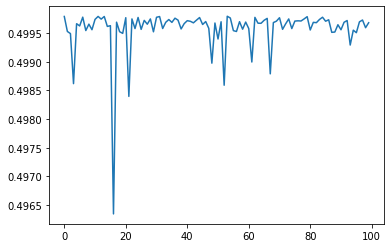

In [449]:
Energy = []
for i in range(0,len(Nodes)):
    Energy.append(Nodes[i].ein)

    
plt.plot(Energy)
plt.show()

In [450]:
Anomalies = [Nodes[25],Nodes[36],Nodes[38],Nodes[39],Nodes[80],Nodes[85],Nodes[92],Nodes[94]] # from Anomaly Detection

In [451]:
# Total Energy before Anomaly Detection
TotalEnergy = 0
for i in range(0,len(Nodes)):
    TotalEnergy = TotalEnergy + Nodes[i].ein

TotalEnergy

49.95779773131

In [452]:
# Total Energy after Anomaly Detection
TotalEnergy_Anomaly = 0
for i in range(0,len(Anomalies)):
    TotalEnergy_Anomaly = TotalEnergy_Anomaly + Anomalies[i].ein
TotalEnergy_Anomaly

3.9971240000000003

In [453]:
Final_Energy = TotalEnergy - TotalEnergy_Anomaly
Final_Energy

45.96067373131

In [454]:
Efficiency = (Final_Energy/TotalEnergy)*100
Efficiency

91.99899879194457

In [455]:
# # for 10000 rounds
def NumberOfRounds(Nodes):
    ResiudalEnergies = []
    NumberOfDeadNodes = [] 
    NumberofCH = []
    for i  in range(0,10):  # number of iterations
        Nai = findAliveNodes(Nodes)
        dsi = findDirectNodes(Nodes)
        Kopti = findKopt(Nai)
        NumberofCH.append(Kopti)
        Nci = findNc(Kopti,Nai)
        dmaxi = findDmax(Nodes,Nci)
        FCHi = findFCH(Nodes,dmaxi)
        Ci = copy.deepcopy(FCHi)
        CHi = findCH(FCHi,Kopti)
        dfi = make_dataframe(df,Kopti)
        ClusterHeadsi = makeClusterHeads(dfi)
        findCHDistance(Nodes,ClusterHeadsi)
        Availi = makeAvailable()
        ClusterNumberi = findClusterNumber(Nodes,ClusterHeadsi,Availi,Nci,Kopti)
        dfi = addWhichCH(dfi)
        dfi = addClusterNumber(dfi)
        updateisCH(dfi,Nodes)
        findEnergyDirectNodes(Nodes)
        findEnergyNonDirectNodes(ClusterHeadsi,Nodes)
        gchi = findGCH(ClusterHeadsi,Nodes)
        Global_CHi = selectGCH(gchi,ClusterHeadsi)

        











